# Example for a simple ReLU MLP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

from matplotlib.colors import LinearSegmentedColormap, ListedColormap, TwoSlopeNorm
from tqdm import tqdm
import matplotlib.patches as mpatches
import random

import numpy as np
from fast_iot.model import ReluMLP

ModuleNotFoundError: No module named 'fast_iot'

In [ ]:
def plot_cell_sdf(
        net,
        resolution: int = 300
    ):
    """
    Plot SDF heatmap with activation boundaries.
    
    Note: This function is designed for 2D input, 1D output models only.
    """
    if net.input_dim != 2 or net.output_dim != 1:
        print(f"Warning: plot_cell_sdf expects 2D input and 1D output, got input_dim={net.input_dim}, output_dim={net.output_dim}")
        return
    
    # ---------- grid & network pass ----------
    x = torch.linspace(-1, 1, resolution)
    y = torch.linspace(-1, 1, resolution)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

    with torch.no_grad():
        net = net.to(device)
        sdf_vals, preacts = net.eval_activations(grid_pts.to(device))  # sdf (N,), acts (N, L*H)

    # infer layer setup
    L = net.num_layers
    H = net.hidden_dim

    sdf_grid = sdf_vals.view(resolution, resolution).cpu().numpy()
    preacts = preacts.view(resolution, resolution, L, H).cpu()

    # ---------- figure ----------
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- SDF heat‑map ----
    vmin, vmax = sdf_grid.min(), sdf_grid.max()
    if vmin >= 0:
        cmap = LinearSegmentedColormap.from_list('pos', ['#ffcccc','red','darkred'])
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    elif vmax <= 0:
        cmap = LinearSegmentedColormap.from_list('neg', ['darkblue','blue','#ccccff'])
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    else:
        cmap = LinearSegmentedColormap.from_list('cent', ['blue','white','red'])
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    im = ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=500, cmap=cmap, norm=norm)

    # ---- activation boundaries ----
    colors = ['cyan', 'darkorange', 'magenta', 'darkred', 'navy', 'brown', 'purple', 'darkslategray'][:L]
    rgba = [plt.matplotlib.colors.to_rgba(c) for c in colors]

    for l in range(L):
        for h in range(H):
            ax.contour(xx.cpu(), yy.cpu(),
                    preacts[:, :, l, h], levels=[0],
                    linewidths=1.2,
                    colors=rgba[l],
                    alpha=0.9,
                    zorder=1)

    # ---- predicted boundary (solid) ----
    cs = ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=[0], colors='black',
               linewidths=1.2, linestyles='--')
    # ---- legend / cosmetics ----
    handles = [mpatches.Patch(color=colors[i], label=f'layer { i+1 } boundary') for i in range(L)]
    ax.legend(handles=handles + ax.get_legend_handles_labels()[0], loc='upper right')

    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('SDF Heat-Map with Activation Boundaries')

    # Create formatter for consistent decimal places
    from matplotlib.ticker import FormatStrFormatter
    
    # Add colorbar with fixed parameters
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.3f'))
    cbar.ax.tick_params(labelsize=8)  # Consistent font size
    cbar.set_label('SDF value', fontsize=10)
    
    # Set a fixed number of ticks
    cbar.locator = matplotlib.ticker.MaxNLocator(nbins=7)
    cbar.update_ticks()

    plt.tight_layout()
    plt.show()

In [ ]:
SEED = 42

# Set Python random seed
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set PyTorch random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# Set PyTorch deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Random seed set to: {SEED}")
print(f"Using device: {device}")

Random seed set to: 42
Using device: cuda


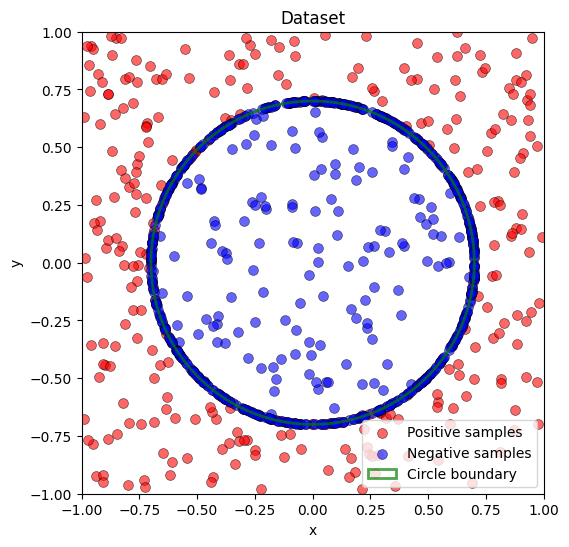

Circle SDF: sqrt(x² + y²) - 0.7
Total samples: 1000 (400 random + 600 on surface)
Positive samples (outside): 308, Negative samples (inside): 692


In [ ]:
# Create a dataset with signed distance to a circle

# Generate points with good spread across the space
n_samples_random = 400  # Random samples to cover the space
n_samples_surface = 600  # Points on the circle surface - more to learn boundary accurately

# Sample uniformly across the entire space
X_random = np.random.uniform(-1, 1, size=(n_samples_random, 2))

# Sample points directly on the circle surface
# Use uniform angles to get evenly distributed points on the circle
circle_radius = 0.7  # Larger radius to fill more of the [-1, 1] domain
angles = np.random.uniform(0, 2*np.pi, size=n_samples_surface)
X_surface = np.stack([
    circle_radius * np.cos(angles),
    circle_radius * np.sin(angles)
], axis=1)

# Combine random and surface samples
X_normalized = np.vstack([X_random, X_surface])

# Define circle SDF: distance to circle centered at origin
# Circle: sqrt(x^2 + y^2) = r
# SDF: sqrt(x^2 + y^2) - r (positive outside, negative inside)
def circle_sdf(x, y):
    # L2 distance from origin minus radius
    return np.sqrt(x**2 + y**2) - circle_radius

y_distance = circle_sdf(X_normalized[:, 0], X_normalized[:, 1])

# Clip to reasonable range
y_distance = np.clip(y_distance, -0.8, 0.8)

# Visualize the dataset
fig, ax = plt.subplots(figsize=(6, 6))

# Separate positive and negative samples
positive_mask = y_distance > 0
negative_mask = y_distance <= 0

# Plot positive samples (above boundary) in red
ax.scatter(X_normalized[positive_mask, 0], X_normalized[positive_mask, 1], 
          c='red', s=50, edgecolors='black', linewidth=0.5, label='Positive samples', alpha=0.6)

# Plot negative samples (below boundary) in blue
ax.scatter(X_normalized[negative_mask, 0], X_normalized[negative_mask, 1], 
          c='blue', s=50, edgecolors='black', linewidth=0.5, label='Negative samples', alpha=0.6)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Dataset')
ax.set_aspect('equal')

# Draw the circle boundary
circle = plt.Circle((0, 0), circle_radius, color='g', fill=False, linewidth=2, alpha=0.7, label='Circle boundary')
ax.add_patch(circle)
ax.legend()

plt.show()

print(f"Circle SDF: sqrt(x² + y²) - {circle_radius}")
print(f"Total samples: {len(X_normalized)} ({n_samples_random} random + {n_samples_surface} on surface)")
print(f"Positive samples (outside): {positive_mask.sum()}, Negative samples (inside): {negative_mask.sum()}")

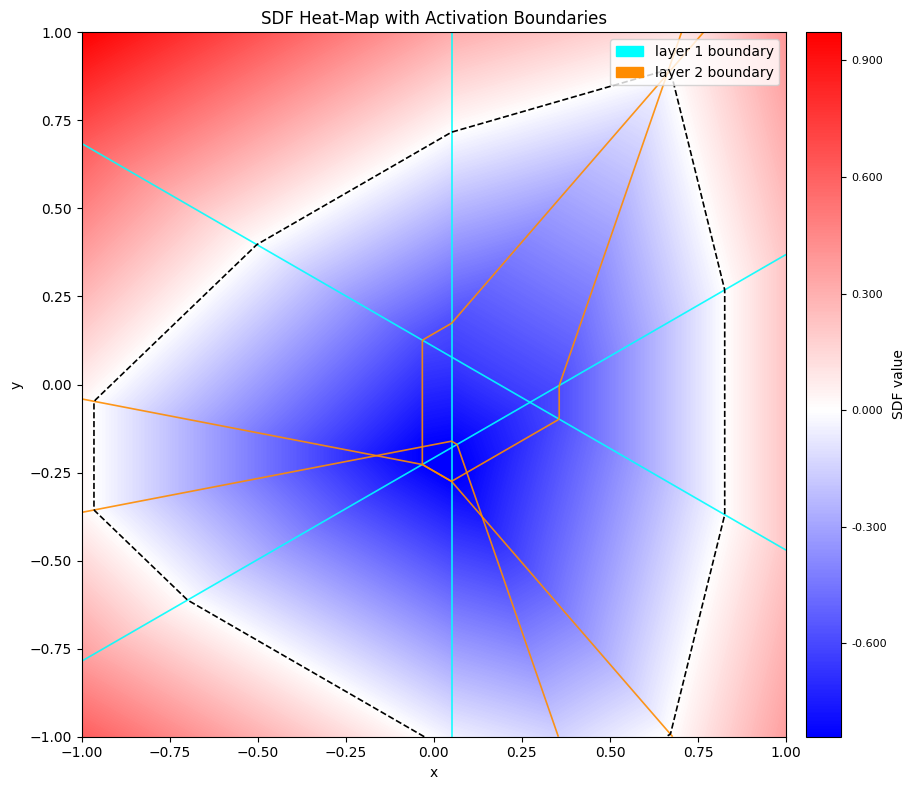

Initialized weights with zero-level sets in [-1, 1] domain


In [ ]:
# Create model with 2D input (x, y coordinates) and 1D output (SDF value)
model = ReluMLP(input_dim=2, hidden_dim=3, num_layers=2, output_dim=1)

# Better initialization: ensure zero level sets intersect the [-1, 1] domain for all layers
# Strategy: use moderate weights and small biases so boundaries appear in the visible domain
with torch.no_grad():
    np.random.seed(SEED)  # For reproducible initialization
    
    # Layer 1: Capture different orientations with zero-level sets in [-1, 1]
    # Use angles at 0°, 120°, 240° and small random biases
    angle1 = 0
    angle2 = 2 * np.pi / 3
    angle3 = 4 * np.pi / 3
    weight_scale = 1.5  # Moderate scale for stable gradients
    
    model.layers[0].weight.data = torch.FloatTensor([
        [weight_scale * np.cos(angle1), weight_scale * np.sin(angle1)],
        [weight_scale * np.cos(angle2), weight_scale * np.sin(angle2)],
        [weight_scale * np.cos(angle3), weight_scale * np.sin(angle3)]
    ])
    # Small biases to ensure boundaries intersect [-1, 1] domain
    model.layers[0].bias.data = torch.FloatTensor([
        np.random.uniform(-0.3, 0.3),
        np.random.uniform(-0.3, 0.3),
        np.random.uniform(-0.3, 0.3)
    ])
    
    # Layer 2: Combine layer 1 outputs with moderate weights and small biases
    model.layers[2].weight.data = torch.FloatTensor([
        [0.6, 0.6, -0.3],
        [-0.3, 0.6, 0.6],
        [0.6, -0.3, 0.6]
    ])
    model.layers[2].bias.data = torch.FloatTensor([
        np.random.uniform(-0.4, 0.4),
        np.random.uniform(-0.4, 0.4),
        np.random.uniform(-0.4, 0.4)
    ])
    
    if len(model.layers) > 4:
        # Layer 3: Further combination with boundaries in visible range
        model.layers[4].weight.data = torch.FloatTensor([
            [0.5, 0.5, -0.3],
            [-0.3, 0.5, 0.5],
            [0.5, -0.3, 0.5]
        ])
        model.layers[4].bias.data = torch.FloatTensor([
            np.random.uniform(-0.5, 0.5),
            np.random.uniform(-0.5, 0.5),
            np.random.uniform(-0.5, 0.5)
        ])
    
    # Output layer: combine all with bias targeting circle radius
    model.layers[-1].weight.data = torch.FloatTensor([[0.7, 0.7, 0.7]])
    model.layers[-1].bias.data = torch.FloatTensor([-circle_radius * 1.2])

plot_cell_sdf(model)
print("Initialized weights with zero-level sets in [-1, 1] domain")


=== Training with MSE Loss ===


Training:   0%|          | 0/5000 [00:00<?, ?it/s, MSE Loss=0.041788, Best=0.041788]

Training: 100%|██████████| 5000/5000 [00:14<00:00, 349.69it/s, MSE Loss=0.000355, Best=0.000353]



Best loss: 0.000353
Loaded best model from training


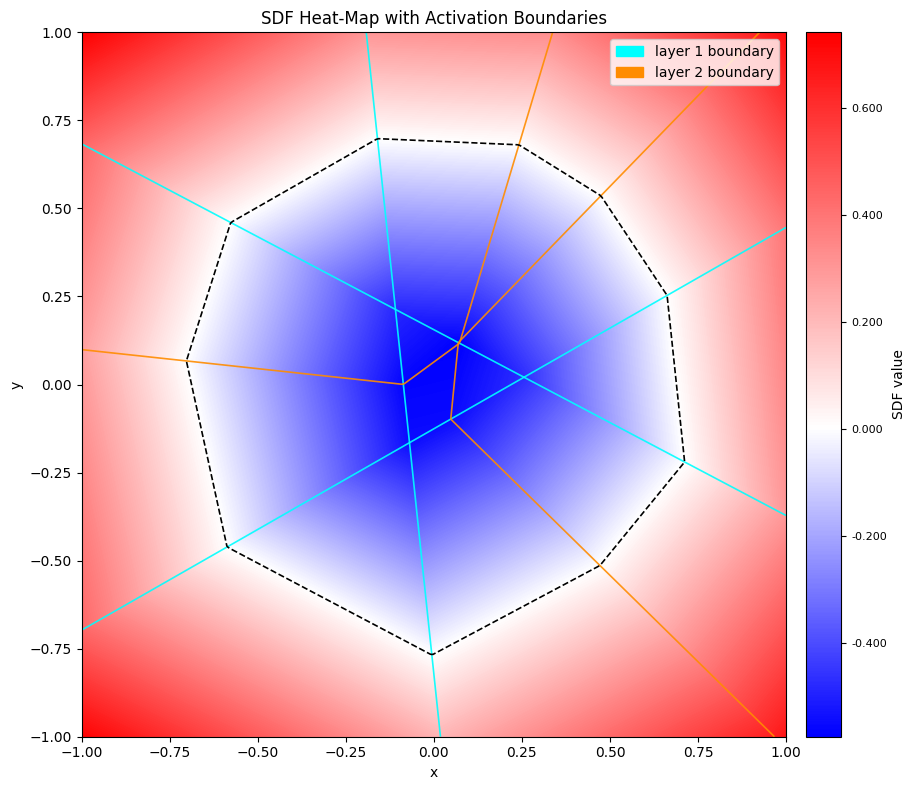

In [ ]:
# Move model to device
model = model.to(device)
# Keep dataset on CPU, move batches to device in training loop
X_tensor = torch.FloatTensor(X_normalized)
y_tensor = torch.FloatTensor(y_distance).reshape(-1, 1)
    
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)  # Lower LR for stable training with scaled weights
# Create DataLoader for batch gradient descent
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
batch_size = 500  # Large batch size for fast, stable training
dataset = TensorDataset(X_tensor, y_tensor)
# Create generator for reproducible DataLoader shuffling
generator = torch.Generator()
generator.manual_seed(SEED)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)
# Training with MSE loss only
print("\n=== Training with MSE Loss ===")
num_epochs = 5000
best_loss = float('inf')
best_model_state = None

pbar = tqdm(range(num_epochs), desc="Training")
for epoch in pbar:
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Move batch to device (DataLoader doesn't do this automatically)
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    # Save best model (based on MSE loss)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict().copy()
    
    # Update progress bar with loss information
    pbar.set_postfix({'MSE Loss': f'{avg_loss:.6f}', 'Best': f'{best_loss:.6f}'})

# Load best model
print(f'\nBest loss: {best_loss:.6f}')
model.load_state_dict(best_model_state)
print("Loaded best model from training")
plot_cell_sdf(model)

Saving preactivation plots to: results/preactivations

=== Layer 1 Preactivations ===
  Saved: layer1_neuron1_preactivation.pdf


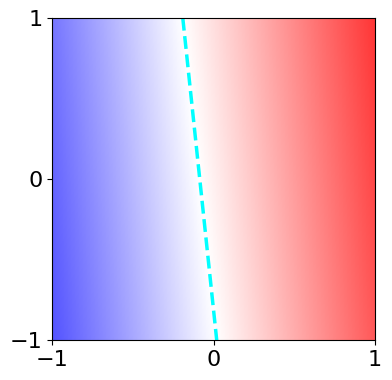

  Saved: layer1_neuron2_preactivation.pdf


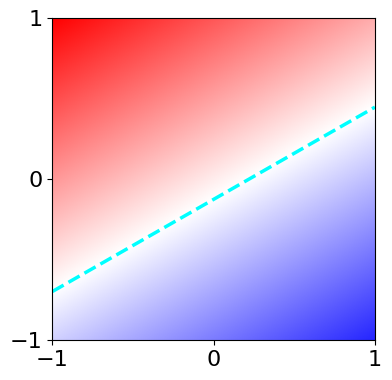

  Saved: layer1_neuron3_preactivation.pdf


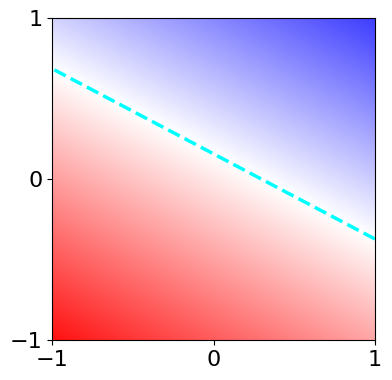


=== Layer 2 Preactivations ===
  Saved: layer2_neuron1_preactivation.pdf


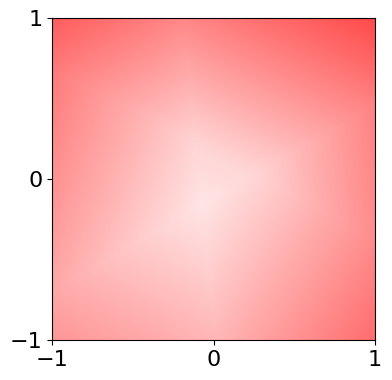

  Saved: layer2_neuron2_preactivation.pdf


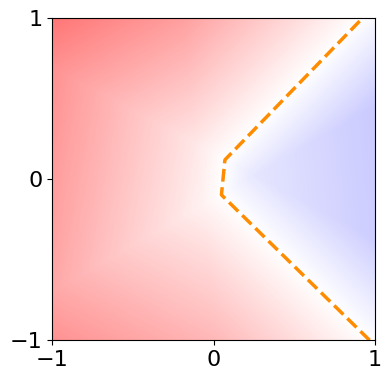

  Saved: layer2_neuron3_preactivation.pdf


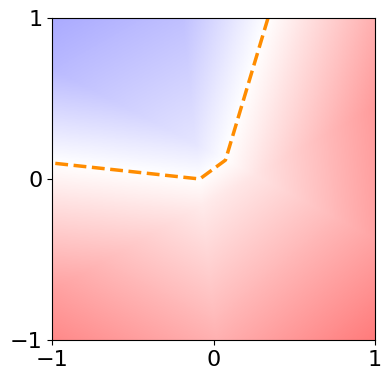


All preactivation plots saved to: results/preactivations


In [ ]:
# Plot each preactivation (before ReLU) for all layers individually
def plot_all_preactivations(model, resolution=400, grid_extent=1.0, save_dir="results/preactivations"):
    """
    Plot preactivation heatmaps for each neuron in each layer, individually.
    
    Args:
        model: ReluMLP model (must have input_dim=2)
        resolution: Grid resolution for visualization
        grid_extent: Visualization range (-grid_extent to +grid_extent)
        save_dir: Directory to save individual plots
    """
    if model.input_dim != 2:
        print(f"Warning: plot_all_preactivations expects 2D input, got input_dim={model.input_dim}")
        return
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    print(f"Saving preactivation plots to: {save_dir}")
    
    # Create grid
    x = torch.linspace(-grid_extent, grid_extent, resolution)
    y = torch.linspace(-grid_extent, grid_extent, resolution)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    
    with torch.no_grad():
        model.eval()
        sdf_vals, preacts = model.eval_activations(grid_pts)
        
        # Get dimensions
        L = model.num_layers
        H = model.hidden_dim
        
        # Reshape preactivations: (N, L*H) -> (resolution, resolution, L, H)
        preacts = preacts.view(resolution, resolution, L, H).cpu()
    
    # Create colormap: blue (negative) -> white (zero) -> red (positive)
    # Use same colormap as visualize_mlp_decision_boundaries
    colors_map = ['blue', 'white', 'red']
    n_bins = 500
    cmap = LinearSegmentedColormap.from_list('custom', colors_map, N=n_bins)
    
    # Define layer colors (darker colors for better visibility)
    layer_colors = ['cyan', 'darkorange', 'magenta', 'darkred', 'navy', 'brown', 'purple', 'darkslategray']
    
    # Compute global vmax across all preactivations for consistent color scaling
    global_vmax = 0
    for layer_idx in range(L):
        for neuron_idx in range(H):
            preact = preacts[:, :, layer_idx, neuron_idx].numpy()
            global_vmax = max(global_vmax, np.abs(preact).max())
    
    if global_vmax == 0:
        global_vmax = 1  # Avoid division by zero
    
    # Plot each neuron individually
    for layer_idx in range(L):
        print(f"\n=== Layer {layer_idx + 1} Preactivations ===")
        
        # Get color for this layer
        layer_color = layer_colors[layer_idx % len(layer_colors)]
        
        for neuron_idx in range(H):
            # Get preactivation for this neuron
            preact = preacts[:, :, layer_idx, neuron_idx].numpy()
            
            # Use global normalization for consistent coloring across all plots
            norm = TwoSlopeNorm(vmin=-global_vmax, vcenter=0, vmax=global_vmax)
            
            # Create individual plot with smaller figure size
            fig, ax = plt.subplots(figsize=(4, 4))
            
            # Plot heatmap
            im = ax.imshow(preact, extent=[-grid_extent, grid_extent, -grid_extent, grid_extent],
                          origin='lower', cmap=cmap, norm=norm, aspect='auto')
            
            # Add zero-level contour (activation boundary) with layer-specific color and dashed line
            ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), preact, 
                      levels=[0], colors=layer_color, linewidths=2.5, linestyles='dashed')
            
            # Set 3 ticks on each axis with larger font size
            ax.set_xticks([-1, 0, 1])
            ax.set_yticks([-1, 0, 1])
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.set_aspect('equal')
            
            # Save individual plot
            filename = f"layer{layer_idx + 1}_neuron{neuron_idx + 1}_preactivation.pdf"
            filepath = os.path.join(save_dir, filename)
            plt.tight_layout()
            plt.savefig(filepath, bbox_inches='tight', dpi=150)
            print(f"  Saved: {filename}")
            plt.show()
            plt.close()
    
    print(f"\nAll preactivation plots saved to: {save_dir}")

# Plot all preactivations individually
plot_all_preactivations(model, resolution=400, grid_extent=1.0, save_dir="results/preactivations")

Saved: network_output.pdf to results/preactivations


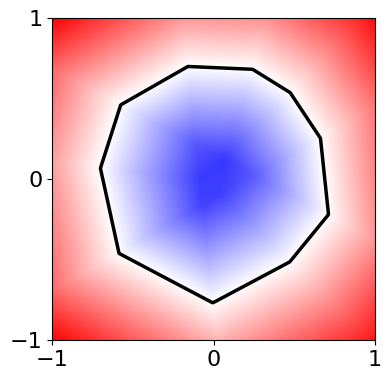

In [ ]:
# Plot network output only
def plot_network_output(model, resolution=400, grid_extent=1.0, save_dir="results/preactivations"):
    """
    Plot the final output of the network.
    
    Args:
        model: ReluMLP model (must have input_dim=2)
        resolution: Grid resolution for visualization
        grid_extent: Visualization range (-grid_extent to +grid_extent)
        save_dir: Directory to save the plot
    """
    if model.input_dim != 2:
        print(f"Warning: plot_network_output expects 2D input, got input_dim={model.input_dim}")
        return
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Create grid
    x = torch.linspace(-grid_extent, grid_extent, resolution)
    y = torch.linspace(-grid_extent, grid_extent, resolution)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    
    with torch.no_grad():
        model.eval()
        # Get network output
        output = model(grid_pts).cpu().numpy()
    
    # Reshape output
    output = output.reshape(resolution, resolution)
    
    # Create colormap: blue (negative) -> white (zero) -> red (positive)
    cmap = LinearSegmentedColormap.from_list('output', ['blue', 'white', 'red'])
    
    # Create diverging colormap centered at zero
    vmax = np.abs(output).max()
    if vmax == 0:
        vmax = 1  # Avoid division by zero
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    # Create plot with smaller figure size
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Plot heatmap
    im = ax.imshow(output, extent=[-grid_extent, grid_extent, -grid_extent, grid_extent],
                  origin='lower', cmap=cmap, norm=norm, aspect='auto')
    
    # Add zero-level contour (decision boundary)
    ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), output, 
              levels=[0], colors='black', linewidths=2.5)
    
    # Set 3 ticks on each axis with larger font size
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_aspect('equal')
    
    # Save plot
    filename = "network_output.pdf"
    filepath = os.path.join(save_dir, filename)
    plt.tight_layout()
    plt.savefig(filepath, bbox_inches='tight', dpi=150)
    print(f"Saved: {filename} to {save_dir}")
    plt.show()
    plt.close()

# Plot network output
plot_network_output(model, resolution=400, grid_extent=1.0, save_dir="results/preactivations")


Saving plots to: results/neuron_plots

=== Plotting Hidden Layer 1 ===
Hidden Layer 1 - Neuron 1


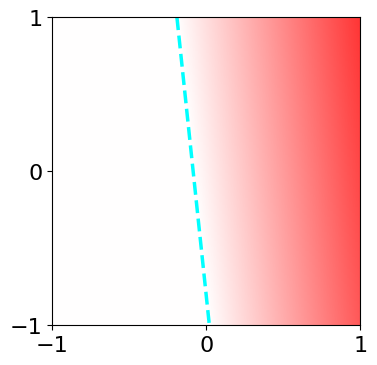

Hidden Layer 1 - Neuron 2


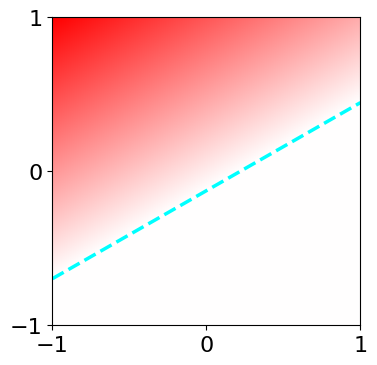

Hidden Layer 1 - Neuron 3


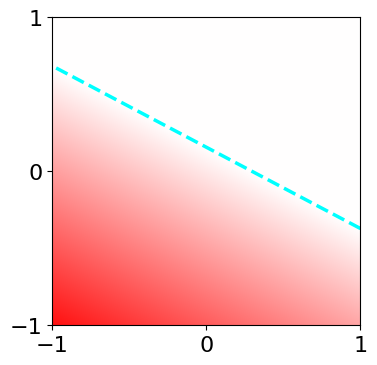


=== Plotting Hidden Layer 2 ===
Hidden Layer 2 - Neuron 1


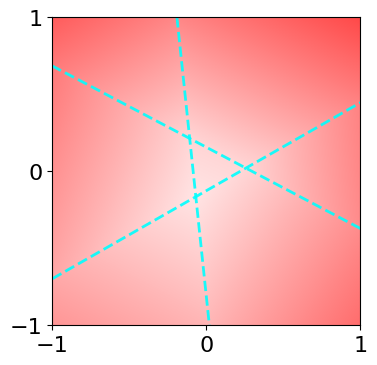

Hidden Layer 2 - Neuron 2


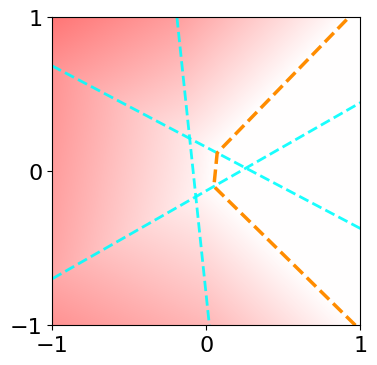

Hidden Layer 2 - Neuron 3


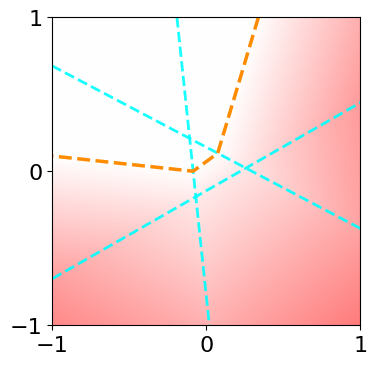


=== Plotting Output Layer ===
Output - Neuron 1


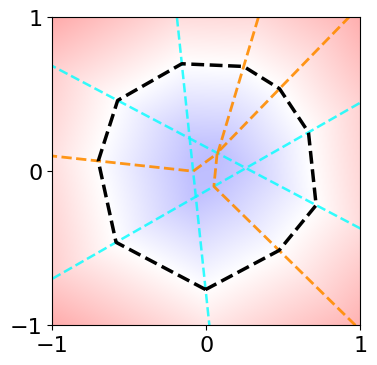


All plots saved to: results/neuron_plots


In [ ]:
#%% Helper functions for plotting
def plot_neuron(layer_name, neuron_idx, Z_after, Z_before, previous_layers_contours, 
                X_grid_xx, X_grid_yy, cmap, grid_extent, results_dir, filename, current_layer_color, vmax):
    """
    Plot a single neuron's activation with previous layer contours.
    
    Args:
        layer_name: Name of the layer (e.g., "Layer 1")
        neuron_idx: Index of the neuron (1-indexed for display)
        Z_after: Activation after ReLU
        Z_before: Activation before ReLU (for contour)
        previous_layers_contours: List of tuples (contours_before, color, linewidth, alpha)
        X_grid_xx, X_grid_yy: Grid for contour plotting
        cmap: Colormap for the heatmap
        grid_extent: Extent of the grid
        results_dir: Directory to save results
        filename: Filename for saving
        current_layer_color: Color for the current layer's contour
        vmax: Maximum value for normalization
    """
    print(f"{layer_name} - Neuron {neuron_idx}")
    
    # Use TwoSlopeNorm for consistent coloring with preactivations
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(Z_after, extent=[-grid_extent, grid_extent, -grid_extent, grid_extent], 
                   origin='lower', cmap=cmap, norm=norm)
    
    # Draw previous layer contours
    for contours, color, linewidth, alpha in previous_layers_contours:
        for contour_data in contours:
            ax.contour(X_grid_xx, X_grid_yy, contour_data, levels=[0], 
                      colors=color, linewidths=linewidth, alpha=alpha, linestyles='dashed')
    
    # Draw current layer contour (before ReLU) with layer-specific color and dashed line
    ax.contour(X_grid_xx, X_grid_yy, Z_before, levels=[0], colors=current_layer_color, 
              linewidths=2.5, linestyles='dashed')
    
    # Set 3 ticks on each axis with larger font size
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_aspect('equal')
    plt.savefig(f"{results_dir}/{filename}", dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

def visualize_mlp_decision_boundaries(model, results_dir, grid_extent=1.0, grid_resolution=500, device='cpu'):
    """
    Generate all decision boundary visualizations for a ReLU MLP.
    
    Note: This function is designed for 2D input models only.
    
    Args:
        model: ReluMLP model (must have input_dim=2)
        results_dir: Directory to save the plots
        grid_extent: Visualization range (-grid_extent to +grid_extent)
        grid_resolution: Resolution of the grid
        device: Device to run computations on
    """
    import os
    import datetime
    
    if model.input_dim != 2:
        print(f"Warning: visualize_mlp_decision_boundaries expects 2D input, got input_dim={model.input_dim}")
        return
    
    # Create results directory
    os.makedirs(results_dir, exist_ok=True)
    print(f"Saving plots to: {results_dir}")
    
    # Setup grid
    X_grid = np.linspace(-grid_extent, grid_extent, grid_resolution)
    X_grid_xx, X_grid_yy = np.meshgrid(X_grid, X_grid)
    X_grid_flat = np.c_[X_grid_xx.ravel(), X_grid_yy.ravel()]
    X_grid_tensor = torch.FloatTensor(X_grid_flat).to(device)
    
    model.eval()
    
    # Create colormap: -1 = blue, 0 = white, 1 = red
    colors_map = ['blue', 'white', 'red']
    n_bins = 500
    cmap = LinearSegmentedColormap.from_list('custom', colors_map, N=n_bins)
    
    # Get number of layers and hidden dimensions
    num_hidden_layers = model.num_layers
    hidden_dim = model.hidden_dim
    
    # Define layer colors (darker colors for better visibility)
    layer_colors = ['cyan', 'darkorange', 'magenta', 'darkred', 'navy', 'brown', 'purple', 'darkslategray']
    
    # Store contours for all layers
    all_contours_before = []
    all_contours_after = []
    
    # Compute global vmax across all post-activations for consistent color scaling
    global_vmax = 0
    
    with torch.no_grad():
        x = X_grid_tensor
        
        # First pass: compute global vmax
        x_temp = X_grid_tensor
        for layer_idx in range(num_hidden_layers):
            linear_idx = layer_idx * 2
            relu_idx = layer_idx * 2 + 1
            
            z_temp = model.layers[linear_idx](x_temp)
            h_temp = model.layers[relu_idx](z_temp)
            h_np_temp = h_temp.cpu().numpy()
            
            global_vmax = max(global_vmax, np.abs(h_np_temp).max())
            x_temp = h_temp
        
        if global_vmax == 0:
            global_vmax = 1  # Avoid division by zero
        
        # Second pass: process and plot each hidden layer
        x = X_grid_tensor
        for layer_idx in range(num_hidden_layers):
            linear_idx = layer_idx * 2
            relu_idx = layer_idx * 2 + 1
            
            # Linear layer
            z = model.layers[linear_idx](x)
            z_np = z.cpu().clone().numpy()
            
            # ReLU layer
            h = model.layers[relu_idx](z)
            h_np = h.cpu().clone().numpy()
            
            # Store contours
            contours_before = []
            contours_after = []
            for i in range(hidden_dim):
                contours_before.append(z_np[:, i].reshape(grid_resolution, grid_resolution))
                contours_after.append(h_np[:, i].reshape(grid_resolution, grid_resolution))
            
            all_contours_before.append(contours_before)
            all_contours_after.append(contours_after)
            
            # Plot neurons for this layer
            print(f"\n=== Plotting Hidden Layer {layer_idx + 1} ===")
            
            # Get color for this layer
            layer_color = layer_colors[layer_idx % len(layer_colors)]
            
            # Build previous layers list
            prev_layers = []
            for prev_idx in range(layer_idx):
                color = layer_colors[prev_idx % len(layer_colors)]
                linewidth = 2.0 - (layer_idx - prev_idx - 1) * 0.3
                alpha = 0.9 - (layer_idx - prev_idx - 1) * 0.1
                prev_layers.append((all_contours_before[prev_idx], color, linewidth, alpha))
            
            # Plot each neuron
            for neuron_idx in range(hidden_dim):
                plot_neuron(f"Hidden Layer {layer_idx + 1}", neuron_idx + 1,
                           contours_after[neuron_idx], contours_before[neuron_idx],
                           prev_layers, X_grid_xx, X_grid_yy, cmap, grid_extent,
                           results_dir, f"layer{layer_idx + 1}_neuron{neuron_idx + 1}.png",
                           layer_color, global_vmax)
            
            # Update x for next layer
            x = h
        
        # Output layer
        print("\n=== Plotting Output Layer ===")
        output = model.layers[-1](x)
        output_np = output.cpu().numpy()
        Z_output = output_np.reshape(grid_resolution, grid_resolution)
        
        # Build previous layers list for output
        prev_layers_output = []
        for prev_idx in range(num_hidden_layers):
            color = layer_colors[prev_idx % len(layer_colors)]
            linewidth = 2.0 - (num_hidden_layers - prev_idx - 1) * 0.2
            alpha = 0.9 - (num_hidden_layers - prev_idx - 1) * 0.1
            prev_layers_output.append((all_contours_before[prev_idx], color, linewidth, alpha))
        
        # Use black for output layer
        plot_neuron("Output", 1, Z_output, Z_output, prev_layers_output,
                   X_grid_xx, X_grid_yy, cmap, grid_extent,
                   results_dir, "output_layer.png", 'black', global_vmax)
    
    print(f"\nAll plots saved to: {results_dir}")

results_dir = f"results/neuron_plots"
visualize_mlp_decision_boundaries(model, results_dir, grid_extent=1.0, grid_resolution=500, device=device)

Saved marching squares visualization to: results/marching_squares.pdf


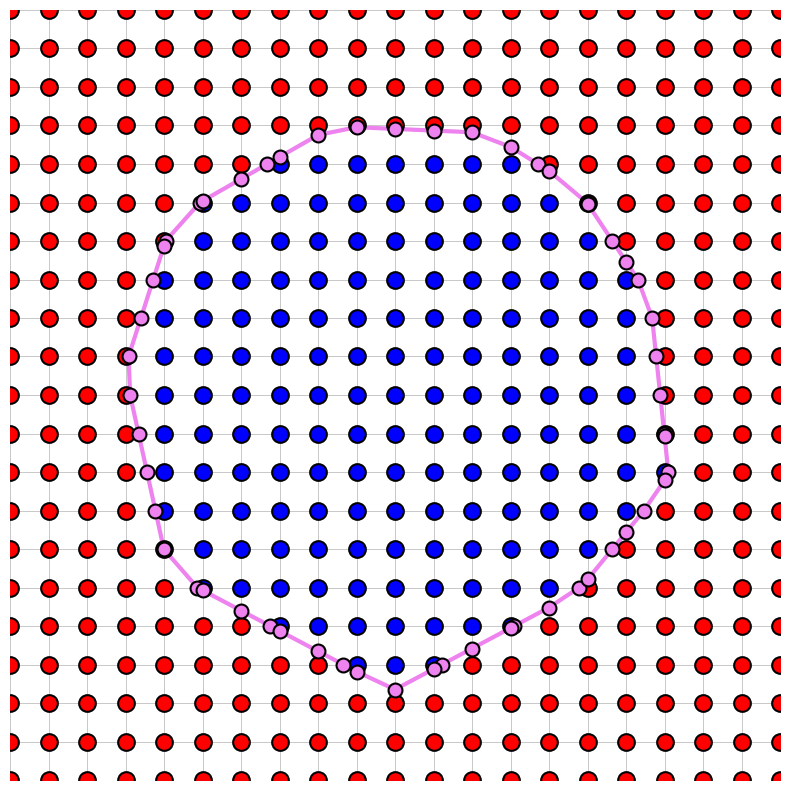

In [ ]:
# Visualize Marching Squares (2D Marching Cubes) algorithm
def visualize_marching_squares(model, resolution=20, grid_extent=1.0, save_path="results/marching_squares.pdf"):
    """
    Visualize the marching squares algorithm on the model's output.
    
    Args:
        model: ReluMLP model (must have input_dim=2)
        resolution: Number of grid cells per dimension
        grid_extent: Domain extent (-grid_extent to +grid_extent)
        save_path: Path to save the visualization
    """
    if model.input_dim != 2:
        print(f"Warning: visualize_marching_squares expects 2D input, got input_dim={model.input_dim}")
        return
    
    # Create coarse grid for visualization
    x = np.linspace(-grid_extent, grid_extent, resolution + 1)
    y = np.linspace(-grid_extent, grid_extent, resolution + 1)
    xx, yy = np.meshgrid(x, y)
    
    # Evaluate model at grid points
    grid_pts = np.stack([xx.flatten(), yy.flatten()], axis=1)
    grid_pts_tensor = torch.FloatTensor(grid_pts).to(device)
    
    with torch.no_grad():
        model.eval()
        values = model(grid_pts_tensor).cpu().numpy().flatten()
    
    # Reshape values to grid
    values_grid = values.reshape(resolution + 1, resolution + 1)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw grid lines
    for i in range(resolution + 1):
        # Horizontal lines
        ax.plot([x[0], x[-1]], [y[i], y[i]], 'k-', linewidth=0.5, alpha=0.3, zorder=1)
        # Vertical lines
        ax.plot([x[i], x[i]], [y[0], y[-1]], 'k-', linewidth=0.5, alpha=0.3, zorder=1)
    
    # Draw grid points (larger, no values)
    for i in range(resolution + 1):
        for j in range(resolution + 1):
            value = values_grid[i, j]
            # Color point based on sign: red for positive (outside), blue for negative (inside)
            color = 'red' if value > 0 else 'blue'
            ax.plot(x[j], y[i], 'o', color=color, markersize=12, 
                   markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    
    # Find crossing points on edges (where sign changes)
    crossing_points = []
    edge_segments = []  # Store which cell each crossing belongs to for connectivity
    
    # Check horizontal edges
    for i in range(resolution + 1):
        for j in range(resolution):
            val_left = values_grid[i, j]
            val_right = values_grid[i, j+1]
            # Check if edge crosses zero (sign change)
            if val_left * val_right < 0:
                # Place crossing point exactly in the middle (50/50)
                cross_x = (x[j] + x[j+1]) / 2
                cross_y = y[i]
                crossing_points.append((cross_x, cross_y))
                edge_segments.append(('h', i, j))  # horizontal edge at row i, column j
    
    # Check vertical edges
    for i in range(resolution):
        for j in range(resolution + 1):
            val_bottom = values_grid[i, j]
            val_top = values_grid[i+1, j]
            # Check if edge crosses zero (sign change)
            if val_bottom * val_top < 0:
                # Place crossing point exactly in the middle (50/50)
                cross_x = x[j]
                cross_y = (y[i] + y[i+1]) / 2
                crossing_points.append((cross_x, cross_y))
                edge_segments.append(('v', i, j))  # vertical edge at row i, column j
    
    # Draw crossing points in violet
    for cross_x, cross_y in crossing_points:
        ax.plot(cross_x, cross_y, 'o', color='violet', markersize=10, 
               markeredgecolor='black', markeredgewidth=1.5, zorder=6)
    
    # Connect crossing points within each cell to form line segments
    for i in range(resolution):
        for j in range(resolution):
            # Get the four edges of this cell and their crossings
            cell_crossings = []
            
            # Bottom edge (horizontal)
            if ('h', i, j) in edge_segments:
                idx = edge_segments.index(('h', i, j))
                cell_crossings.append(crossing_points[idx])
            
            # Top edge (horizontal)
            if ('h', i+1, j) in edge_segments:
                idx = edge_segments.index(('h', i+1, j))
                cell_crossings.append(crossing_points[idx])
            
            # Left edge (vertical)
            if ('v', i, j) in edge_segments:
                idx = edge_segments.index(('v', i, j))
                cell_crossings.append(crossing_points[idx])
            
            # Right edge (vertical)
            if ('v', i, j+1) in edge_segments:
                idx = edge_segments.index(('v', i, j+1))
                cell_crossings.append(crossing_points[idx])
            
            # Connect the crossings (typically 0, 2, or 4 crossings per cell)
            if len(cell_crossings) == 2:
                p1, p2 = cell_crossings
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'violet', linewidth=3, zorder=4)
    
    ax.set_xlim(-grid_extent, grid_extent)
    ax.set_ylim(-grid_extent, grid_extent)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axes
    
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    print(f"Saved marching squares visualization to: {save_path}")
    plt.show()
    plt.close()

# Visualize marching squares
visualize_marching_squares(model, resolution=20, grid_extent=1.0, save_path="results/marching_squares.pdf")
